## Mount Drive & Import pkgs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
# change dir
import os

In [4]:
import sys
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm
import re

## Read & clean file

In [5]:
data = pd.read_csv('./教科書課文.csv', encoding='utf-8',index_col=False)
len(data)

114

In [6]:
data.head()

,No.,Subject,Grade,Year,Publisher,Type,Lesson,Tittle,Content
0,D001,國語,6下,91,國立編譯館,text,1,生活處處美,"生活處處美\n\n餐桌上的美人\n晚餐時媽媽做了她的拿手好菜—糖醋里肌,材料除了裹粉油炸成金..."
1,D002,國語,6下,91,國立編譯館,text,2,梅樹飄香,"五十多年前的一天,天上飄著細雨,李梅樹走出三峽民生街李家老宅,穿過街旁的小巷,走向祖師廟。這..."
2,D003,國語,6下,91,國立編譯館,text,3,胸有丘壑張大千,"胸有丘壑張大千\n\n一襲長袍,一把長長的鬍鬚,張大千在護士小姐扶持下,顫巍巍的來到那幅巨大..."
3,D004,國語,6下,91,國立編譯館,text,4,天涯若比鄰,"你有沒有想過:當你正興高采烈的和同學玩耍時,在地球遙遠的另一端,那兒的小朋友還沉睡在夢鄉中呢..."
4,D005,國語,6下,91,國立編譯館,text,5,小故事的啟示,"小故事的啟示\n讓路給小鴨子!這是真的嗎?美國鄉村公路上車輛不多,公路兩邊林木茂盛,常會看見..."


In [7]:
df = data[['Grade', 'Year',	'Lesson', 'Tittle', 'Content']]
len(df)

114

In [58]:
# Clean
trash_re = "@\S+|https?:\S+|http?:\S|[^\u4E00-\u9FD5]"

def clean(texts, trash_re):
    output = []
    for text in texts:
        text = re.sub(trash_re, ' ', str(text)) # 以空格取代標點
        output.append(text)
    return output

In [91]:
# process Clean
all_lines = []

for lesson in df['Content'].tolist():
  lines = lesson.splitlines()
  newlines = []
  for l in lines: # 清掉空白句
    if len(l) > 0:
      newlines.append(l)
  all_lines.append(newlines)

In [ ]:
# 加回df
df['Content_split'] = all_lines
df.head()

In [110]:
df.to_pickle('./textbook_df.pkl')

## WSD

### install import pkgs

In [4]:
!git clone https://github.com/seantyh/dwsd-beta

fatal: destination path 'dwsd-beta' already exists and is not an empty directory.


In [ ]:
!pip install -q CwnGraph transformers

In [6]:
import sys
if "dwsd-beta" not in sys.path:
  sys.path.append("dwsd-beta")

In [7]:
from dotted_wsd import DottedWsdTagger

updating manifest...
manifest version:  v2022.08


In [ ]:
tagger = DottedWsdTagger()

DistilTag

In [ ]:
pip install -U DistilTag

In [ ]:
import DistilTag
DistilTag.download()

In [ ]:
from DistilTag import DistilTag
distilTagger = DistilTag()

test = distilTagger.tag('貝多芬今天去台大打球')
test[0]

### process df

In [12]:
'''texts: list of lists(Tagged好的sentence) of tuples(lemma)'''
def get_dotted_wsd(texts):  

  id_pattern = '\[(.*?)\]'
  con_pattern = '\((.*?)\)'
  gloss_pattern = '(\[|\()\S+(\]|\))|\s'

  datalist = []
  for sentence in texts:
    tt = tagger.sense_tag_per_sentence(sentence)
    for word in tt:
      one_lemma = word[0]
      one_pos = word[1]
      if len(word[2]) > 0:
        id_search = re.search(id_pattern, word[2])
        con_search = re.search(con_pattern, word[2])

        one_senseID = id_search[0][1:-1]
        one_confidence = con_search[0][1:-1]
        one_gloss = re.sub(gloss_pattern, '', word[2])
      else:
        one_gloss = ''
        one_senseID = ''
        one_confidence = ''
      
      # 一個lemma的資料
      one_data = [one_lemma, one_pos, one_senseID, one_gloss, one_confidence]
      datalist.append(one_data)
      
  return datalist # list of lists(lemma) of string(lemma features)

In [13]:
tagged = distilTagger.tag('我：是誰、你是誰？他,是誰。')
get_dotted_wsd(tagged)

[['我', 'Nh', '05238701', '代指說話者。', '0.7796'],
 ['：', 'COLONCATEGORY', '', '', ''],
 ['是', 'SHI', '07023505', '表後述動作的受事者是前述對象。', '0.9913'],
 ['誰', 'Nh', '04090701', '代指詢問一個或多數的人。', '0.9847'],
 ['、', 'PAUSECATEGORY', '', '', ''],
 ['你', 'Nh', '05238601', '代指單數的聽話者。', '0.6614'],
 ['是', 'SHI', '07023505', '表後述動作的受事者是前述對象。', '0.9959'],
 ['誰', 'Nh', '04090701', '代指詢問一個或多數的人。', '0.9942'],
 ['？', 'QUESTIONCATEGORY', '', '', ''],
 ['他', 'Nh', '05238501', '代指自己和對方以外的第三人。', '0.7466'],
 ['，', 'COMMACATEGORY', '', '', ''],
 ['是', 'SHI', '07023505', '表後述動作的受事者是前述對象。', '0.9968'],
 ['誰', 'Nh', '04090701', '代指詢問一個或多數的人。', '0.9933'],
 ['。', 'PERIODCATEGORY', '', '', '']]

process Content_split

In [14]:
df = pd.read_pickle('./textbook_df.pkl')
df.head()

,Grade,Year,Lesson,Tittle,Content,Content_split
0,6下,91,1,生活處處美,"生活處處美\n\n餐桌上的美人\n晚餐時媽媽做了她的拿手好菜—糖醋里肌,材料除了裹粉油炸成金...","[生活處處美, 餐桌上的美人, 晚餐時媽媽做了她的拿手好菜—糖醋里肌,材料除了裹粉油炸成金黃..."
1,6下,91,2,梅樹飄香,"五十多年前的一天,天上飄著細雨,李梅樹走出三峽民生街李家老宅,穿過街旁的小巷,走向祖師廟。這...","[五十多年前的一天,天上飄著細雨,李梅樹走出三峽民生街李家老宅,穿過街旁的小巷,走向祖師廟。..."
2,6下,91,3,胸有丘壑張大千,"胸有丘壑張大千\n\n一襲長袍,一把長長的鬍鬚,張大千在護士小姐扶持下,顫巍巍的來到那幅巨大...","[胸有丘壑張大千, 一襲長袍,一把長長的鬍鬚,張大千在護士小姐扶持下,顫巍巍的來到那幅巨大的..."
3,6下,91,4,天涯若比鄰,"你有沒有想過:當你正興高采烈的和同學玩耍時,在地球遙遠的另一端,那兒的小朋友還沉睡在夢鄉中呢...","[你有沒有想過:當你正興高采烈的和同學玩耍時,在地球遙遠的另一端,那兒的小朋友還沉睡在夢鄉中..."
4,6下,91,5,小故事的啟示,"小故事的啟示\n讓路給小鴨子!這是真的嗎?美國鄉村公路上車輛不多,公路兩邊林木茂盛,常會看見...","[小故事的啟示, 讓路給小鴨子!這是真的嗎?美國鄉村公路上車輛不多,公路兩邊林木茂盛,常會看..."


In [ ]:
all_lessons = []

for lesson in tqdm(df['Content_split'].tolist()):
  datas_of_lesson = []
  for line in tqdm(lesson):
    tagged = distilTagger.tag(line)
    datas_of_line = get_dotted_wsd(tagged)
    datas_of_lesson += datas_of_line

  all_lessons.append(datas_of_lesson)

df['list_of_senses'] = all_lessons
df.to_pickle('./textbook_wsd.pkl')

## Sense statistics

### inspect

In [ ]:
data = pd.read_pickle('./textbook_wsd.pkl')
data.head()

build WSD df (1 sense per row)

In [110]:
grades, lessons, titles, lemmas, pos, sids, defs = [], [], [], [], [], [], []

for i,r in data.iterrows():
  g = r['Grade']
  les = r['Lesson']
  t = r['Tittle']
  for s in r['list_of_senses']:
    grades.append(g)
    lessons.append(les)
    titles.append(t)
    s = tuple(s[:-1])
    lemmas.append(s[0])
    pos.append(s[1])
    sids.append(s[2])
    defs.append(s[3])

wsd_df = pd.DataFrame({'grade':grades, 'lesson':lessons, 'title':titles, 
                       'lemma':lemmas, 'pos':pos, 'sid':sids, 'definition':defs})


In [111]:
wsd_df[:3]

,grade,lesson,title,lemma,pos,sid,definition
0,6下,1,生活處處美,生活,Na,06743601,日常活動的情況。
1,6下,1,生活處處美,處處,D,,
2,6下,1,生活處處美,美,VH,06634803,形容比喻可以引起他人愉悅情感的。


In [112]:
wsd_df.to_pickle('./wsd_df.pkl')

#### Freq of senses 的，還，就，也，又

In [55]:
targets = ['的','還','就','也','又']
wsd_df.loc[wsd_df['lemma'].isin(targets)].groupby('lemma').size()

lemma
也     251
又     163
就     374
的    3185
還     127
dtype: int64

In [56]:
ddf = wsd_df.loc[wsd_df['lemma'].isin(targets)]

In [58]:
# 的freq
ddf[ddf['lemma']=='的'].groupby('definition').size()

definition
列舉相類似的事物。               838
表一般的修飾關係，用於修飾語和中心語間。    395
表以前述動作的狀態。              460
表使謂語具名詞性，用於主語和謂語間。      395
表前述對象是離合動賓動詞的賓語。          6
表在前述情況下。                277
表對推論的肯定。                 18
表肯定或加強的語氣。              218
表領屬關係，用於修飾語和中心語間。       578
dtype: int64

In [59]:
# 還freq
ddf[ddf['lemma']=='還'].groupby('definition').size()

definition
交回、歸還。             2
恢復、回復原來的狀態。        2
表事情尚未完成。          14
表前述對象符合讓步後的條件。     7
表前述範圍之外有所補充。      71
表動作或情況持續不變。       22
表程度高於比較對象。         1
表超出預料。             5
返回、回來原來的地方。        3
dtype: int64

In [57]:
# 就freq
ddf[ddf['lemma']=='就'].groupby('definition').size()

definition
用於轉折，表與聽話者有共識。                      16
表前述事件為後述事件的充分條件，表示在該條件或情況下自然發展。    159
表前述情況已滿足主觀的最低條件。                     8
表加強說話者對陳述內容的肯定。                     99
表強調說話者已知事實。                         12
表後述事件在很短的時間內完成。                      4
表後述事件發生的時間比預期早。                      7
表後述事件緊接著前述事件發生。                     65
表後述命題和前文相對，具有轉折的語氣。                  2
表無所謂的讓步。                             1
表確定範圍。                               1
dtype: int64

In [60]:
# 也freq
ddf[ddf['lemma']=='也'].groupby('definition').size()

definition
表在特定情況下，沒有一定的作法。     5
表委婉的語氣。             24
表所描述的對象屬於同一類。       81
表示判斷或解釋的語氣。          5
表示疑問或反問的語氣。          2
表與預期的情況相反。          13
表讓步的語氣。              4
表預期會改變的情況維持不變。      34
連接兩個有關連性的事件。        83
dtype: int64

In [61]:
# 又freq
ddf[ddf['lemma']=='又'].groupby('definition').size()

definition
表事件重複發生。                  58
表另外。                       4
表接連發生事件中的後述發生事件。          15
表示加強的語氣。                   4
表轉折。                      10
言談中用來表主題的轉折。               5
連接下一級的計數單位，表示整數之外再加零數。     9
連接兩對等詞組，表兩種狀況同時存在。        58
dtype: int64

#### Distr of grade 的

In [113]:
ddf = wsd_df.loc[wsd_df['lemma'].isin(targets)]

In [ ]:
pd.set_option('display.max_rows',None)
pd.DataFrame(ddf[ddf['lemma']=='的'].groupby(['definition','grade']).size()).rename({0:'count'},axis=1)

In [ ]:
df_DE = pd.DataFrame(ddf[ddf['lemma']=='的']).sort_values(['grade','definition']).reset_index(drop=True)

In [116]:
df_DE.to_csv('./df_DE.csv',encoding='utf-8',index=False)

## Visualization

中文

In [25]:
import matplotlib as mpl
import matplotlib.font_manager as fm
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

In [6]:
fm.fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
mpl.rc('font', family='Taipei Sans TC Beta')

group definition

In [8]:
df_DE = pd.read_csv('./df_DE.csv',encoding='utf-8',index_col=False)
df_DE.head()

,grade,lesson,title,lemma,pos,sid,definition
0,3上,3,小動物的本事,的,DE,7023408,列舉相類似的事物。
1,3上,3,小動物的本事,的,DE,7023408,列舉相類似的事物。
2,3上,3,小動物的本事,的,DE,7023408,列舉相類似的事物。
3,3上,9,可貴的筆記本,的,DE,7023408,列舉相類似的事物。
4,3上,9,可貴的筆記本,的,DE,7023408,列舉相類似的事物。


In [11]:
len(list(set(df_DE['definition'].tolist())))

9

In [47]:
df_DE.groupby('definition').size()

definition
列舉相類似的事物。               838
表一般的修飾關係，用於修飾語和中心語間。    395
表以前述動作的狀態。              460
表使謂語具名詞性，用於主語和謂語間。      395
表前述對象是離合動賓動詞的賓語。          6
表在前述情況下。                277
表對推論的肯定。                 18
表肯定或加強的語氣。              218
表領屬關係，用於修飾語和中心語間。       578
dtype: int64

#### Frequency of \'的\' senses

Text(0, 0.5, '')

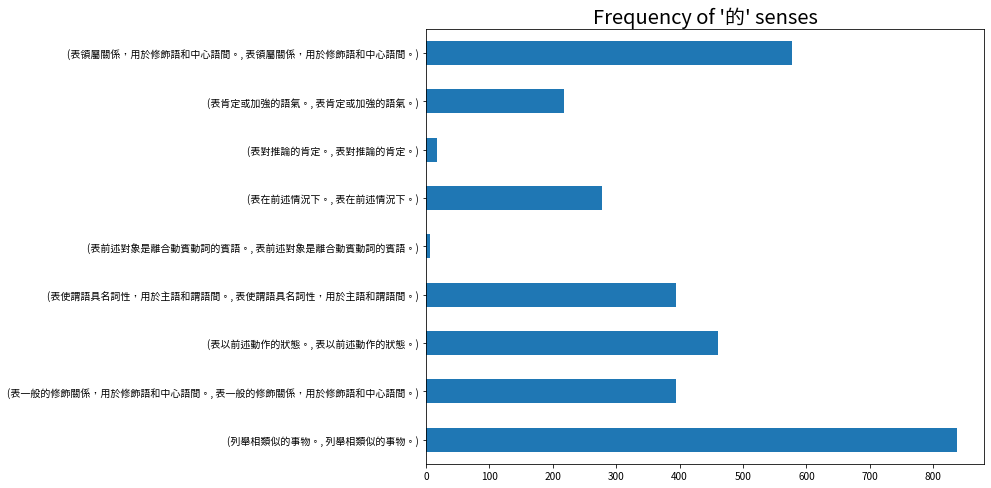

In [44]:
r = df_DE.groupby('definition').definition.value_counts().plot.barh(figsize=(10,8))
r.set_title("Frequency of \'的\' senses",fontdict={'fontsize':20})
r.set_ylabel('')

#### Distribution of \'的\' senses

Text(0.5, 1.0, "Distribution of '的' senses")

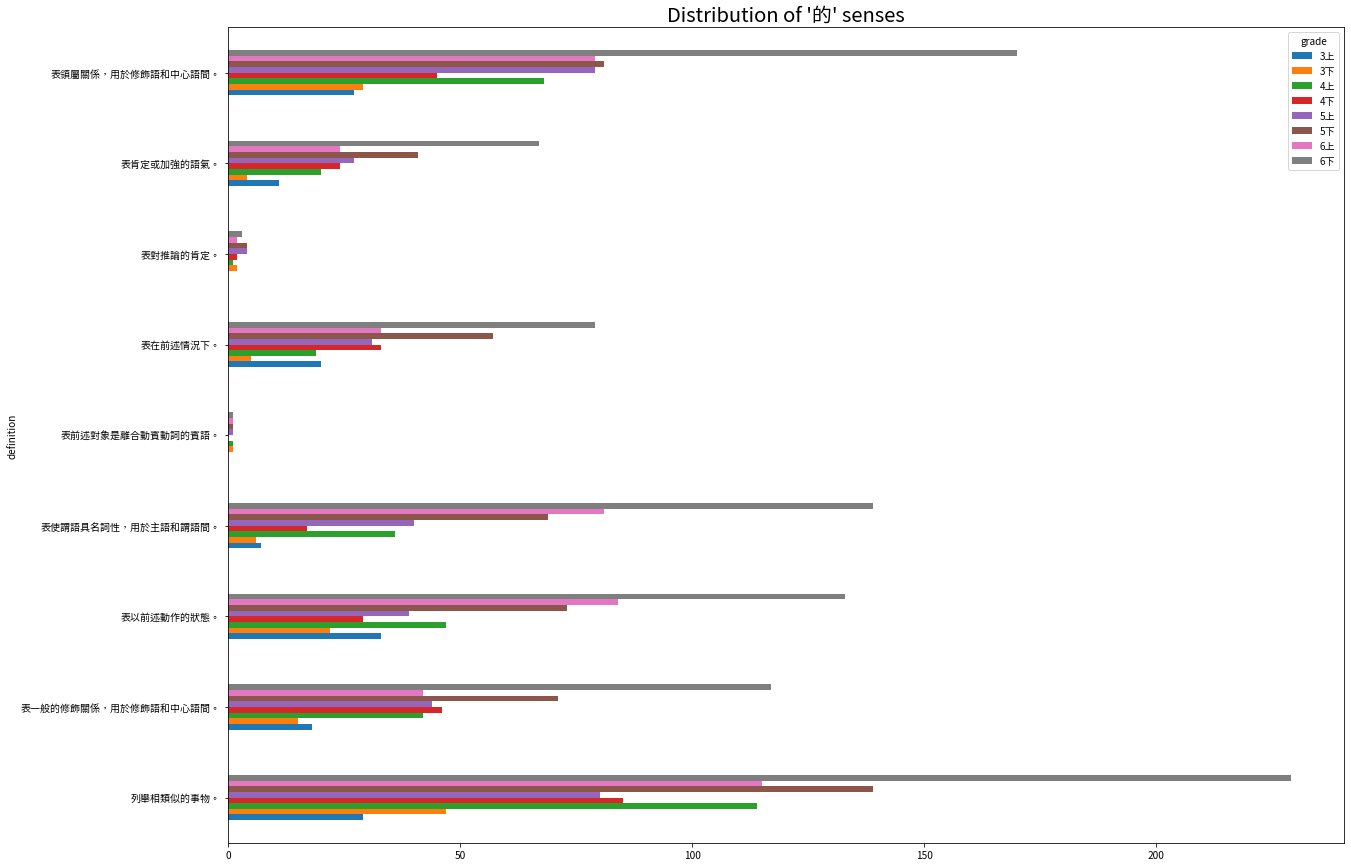

In [36]:
result = df_DE.groupby(['grade']).definition.value_counts().unstack(0).plot.barh(figsize=(20,15))
result.set_title("Distribution of \'的\' senses",fontdict={'fontsize':20})